## Matthew Adams - 06-681 Final Project

## Using Machine-learning to predict adsorbate binding energies of active sites

### Introduction

     Calculating binding energies of adsorbates on surface active sites is a critical part of evaluating a catalyst's performance. The most traditional method of calculating these binding energies is through Density functional theory (DFT) calculations due to its high accuracy. Unfortunately, this high accuracy comes with a high computational cost, which leads to this method becoming a major bottleneck in the catalyst discovery process. Due to the immense amount of possible surfaces that remain undiscovered, it is necessary for the development of ways to improve the efficiency of the search process. In the recent years, the usage of machine-learning techniques in materials science and chemical engineering has dramatically increased due to the shown success of these methods. 
 
     In order to produce a dataset to test the machine-learning model, the Effective Medium Theory (EMT) calculator from the Atomic Simulation Environment[1] (ASE) package will be used as its calculation time is on the timescale of seconds compared to DFT's timescale of days for the same system. As seen from the figure below, the goal of this project is to be able to successfully predict the property (in this case it is the binding energy of Carbon) for each active site structure based on their properties which will be enumerated into a readable vector format for the model.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0010465519303042-gr1.jpg">

    Fig. 1. Typical workflow for making machine learning based materials property predictions for atomistic structures[2].

## Methods

### 1. Generating the dataset
#### I. Creating the structures
        The ASE package provides tools which allow for the construction of simple bulk crystals and surfaces. For this project, only the FCC (111) surface was considered for all calculations. Unfortunately, the variety in data points was limited due to the the EMT calculator's limited support of the following metals : Al, Ni, Cu, Pd, Ag, Pt, Au. To increase the dataset size, all possible combinations of the elements were considered when creating the surfaces. Once all of the surfaces were calculated and stored in their respective databases, the binding energy of Carbon was able to be calculated for each of their respective binding sites. Each surface had binding energies calculated for the 4 active sites listed on ASE (fcc, hcp, ontop, bridge). With this method, a total of 280 data points were generated in total.
        
    

   

In [1]:
# Required libraries to run this notebook
!pip install ase
!pip install dscribe

In [2]:
#Importing required libraries
import numpy as np
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.eos import calculate_eos
from ase.db import connect

db = connect('bulk.db') #creates a database to store bulk calculation data results
for symb in ['Al', 'Ni', 'Cu', 'Pd', 'Ag', 'Pt', 'Au']: #loop which runs EMT bulk calculation for all supported elements
    atoms = bulk(symb, 'fcc')
    atoms.calc = EMT()
    eos = calculate_eos(atoms) #calcu
    v, e, B = eos.fit()  # find min energy state
    atoms.cell *= (v / atoms.get_volume())**(1 / 3) 
    lattice_constant = (4*v)**(1/3) #formula for lattice constant (used for surface calculations)
    atoms.get_potential_energy()
    db.write(atoms, lc=lattice_constant) #writes calculation results to database to be used later


In [3]:
#Building surfaces

from ase.calculators.emt import EMT
from ase.db import connect
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.build import molecule


db1 = connect('bulk.db') #database from before
db2 = connect('ads.db') #create database for adsorption calculations
sites = ['fcc','hcp','bridge','ontop']

structures=[] #empty list to add all structures, used for enumerating the sites
def run(symb, a, n, ads,position):
    atoms = fcc111(symb, (2, 2, n), a=a)
    add_adsorbate(atoms, ads, height=1.5, position=position) 
    structures.append(atoms)
    # Constrain all atoms except the adsorbate:
    fixed = list(range(len(atoms) -1))
    atoms.constraints = [FixAtoms(indices=fixed)]
    atoms.calc = EMT()
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=0.05)
    return atoms


for row in db1.select():
    a = row.lc
    symb = row.symbols[0]
    ads = 'C'
    #adsorbates = [molecule('C3H6_Cs')]
    for i in range(len(sites)):   #calculate for each site in a loop
        position = sites[i]
        for i in range(len(ads)):
            atoms = run(symb, a, 2, 'C',position)
            db2.write(atoms, layers=2, surf=symb,ads=ads,site=position)
            


In [4]:
# Building surfaces with adsorbate

from ase.build import molecule
from ase import Atoms
# Reference Energies
refs = connect('refs.db')
a = Atoms('C')
a.calc = EMT()
a.get_potential_energy()
refs.write(a)


db3 = connect('surfaces.db')

def run(symb, a, n, ads,position):
    atoms = fcc111(symb, (2, 2, n), a=a)
    # Constrain all atoms except the adsorbate:
    fixed = list(range(len(atoms) -1))
    atoms.constraints = [FixAtoms(indices=fixed)]
    atoms.calc = EMT()
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=0.05)
    return atoms


for row in db1.select():  
    a = row.lc
    symb = row.symbols[0]
    ads = 'clean'
    #adsorbates = [molecule('C3H6_Cs')]
    atoms = run(symb, a, 2, 'clean',position)
    db3.write(atoms, layers=2, surf=symb,ads=ads,site=position)

In [5]:
# Building bimetallic surfaces

import itertools as it 
from ase.build import surface
symbols = ['Al', 'Ni', 'Cu', 'Pd', 'Ag', 'Pt', 'Au']
alloys = []
for a,b in it.combinations(symbols,2):
    alloys.append(a+3*b)
    alloys.append(3*a+b)
    alloys.append(2*a+2*b)

a = 4.0
from ase import Atoms
bimetal_surfaces = []
for i in range(len(alloys)):
    bimetals = Atoms(str(alloys[i]),
              scaled_positions=[(0, 0, 0),
                                (0.5, 0.5, 0),
                                (0.5, 0, 0.5),
                                (0, 0.5, 0.5)],
              cell=[a, a, a],
              pbc=True)
    #print(bimetals)
    s3 = surface(bimetals, (1, 1, 1), 2)
    bimetal_surfaces.append(s3)
    
#print(bimetal_surfaces)





In [6]:
#bimetallic surfaces

db4 = connect('bimetals.db')

alloy_structures=[]
def run(symb, a, n, ads,position):
    atoms = symb
    #print(atoms)
    alloy_structures.append(atoms)
    # Constrain all atoms except the adsorbate:
    fixed = list(range(len(atoms)))
    atoms.constraints = [FixAtoms(indices=fixed)]
    atoms.calc = EMT()
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=0.05)
    return atoms

for i in range(len(bimetal_surfaces)):
    a = 4
    symb = bimetal_surfaces[i]
    atoms = run(symb, a, 1, 'clean',position)
    db4.write(atoms, layers=2, surf=str(alloys[i]),ads='clean',site=position)
            



In [7]:
#Note: It seems ASE does not support named sites for non-common surfaces, so I used the corresponding coordinates (from ase gui)
#
#bimetallic surface+ adsorbate at each active site
# This part takes ~1 minute to run

fcc = (1.414, 0.816)
hcp = (2.828,1.633)
bridge = (1.414,0)
ontop = (0,0)
sites = [fcc,hcp,bridge,ontop]

db4 = connect('bimetals.db')
db5 = connect('bimetal_adsorption.db')
bimetal_structures = []

def run(symb, a, n, ads,position):
    bimetals = Atoms(str(symb),
              scaled_positions=[(0, 0, 0),
                                (0.5, 0.5, 0),
                                (0.5, 0, 0.5),
                                (0, 0.5, 0.5)],
              cell=[a, a, a],
              pbc=True)
    atoms = surface(bimetals, (1, 1, 1), 2)  # fcc(111), 2 layers
    add_adsorbate(atoms, ads, height=1.5, position=position)
    bimetal_structures.append(atoms)
    # Constrain all atoms except the adsorbate:
    fixed = list(range(len(atoms) -1))
    atoms.constraints = [FixAtoms(indices=fixed)]
    atoms.calc = EMT()
    opt = BFGS(atoms, logfile=None)
    opt.run(fmax=0.05)
    return atoms

for row in db4.select():
    a = 4
    symb = alloys[row.id-1]
    #ads = 'C'
    for i in range(len(sites)): 
        position = sites[i]  #runs through the loop of active sites
        atoms = run(symb, a, 2, 'C',position)
        db5.write(atoms, layers=2, surf=str(symb),ads='C',site=str(sites[i]))

## II. Calculating the Binding energies
    Using the energies from the data structures that were previously generated, the binding energy can be found with the following equation:
        
        E(Adsorbate+Surface)- E(Adsorbate) - E(Surface) = E(binding)
 
    These calculated values will be used to train our model and test its accuracy in predicting the true binding energies.

In [8]:
from ase.db import connect

db = connect('ads.db')
refs = connect('refs.db')
surfaces = connect('surfaces.db')
ea_list = []
for row in db.select():
    ea = (row.energy - refs.get(formula=row.ads).energy - surfaces.get(surf=row.surf).energy)
    ea_list.append(ea)
    #db.update(row.id,ea=ea)
#print(ea_list)
#Binding Energies for Carbon of each monometallic surface site

alloy_db = connect('bimetal_adsorption.db')
refs = connect('refs.db')
surfaces = connect('bimetals.db')
ea_list2 = []
for row in alloy_db.select():
    ea = (row.energy - refs.get(formula=row.ads).energy - surfaces.get(surf=row.surf).energy)
    ea_list2.append(ea)
    #alloy_db.update(row.id,ea=ea)
#print(ea_list2)

In [9]:
# Attempt to create a pandas dataframe for Carbon atom (not human friendly?)
import sqlite3
import pandas as pd
con = sqlite3.connect('refs.db')
df = pd.read_sql('SELECT * FROM systems',con)
print(df)


   id                         unique_id      ctime      mtime username  \
0   1  5d3e0b72fd1e2886db7242aab0f341d1  20.306297  20.306297     None   

               numbers                                          positions  \
0  b'\x06\x00\x00\x00'  b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...   

                                                cell  pbc initial_magmoms  \
0  b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...    0            None   

   ... magmom charges key_value_pairs                                   data  \
0  ...   None    None              {}  b'\x08\x00\x00\x00\x00\x00\x00\x00{}'   

  natoms fmax  smax  volume    mass charge  
0      1  0.0  None    None  12.011    0.0  

[1 rows x 33 columns]


## III. Enumerating each active site
    
    As seen from the table above, each structure contains information that characterizes each individual site such as atomic numbers and positions. From this data, one can create a numerical vector of features of atomic properties for each active site. The descriptor used for feature transformation of the active sites was the Smooth Overlap of Atomic Positions (SOAP) which is a part of the DScribe software package[2]. This package is compatible with ASE files, and only requires the structures as an input to featurize. Additionally, this descriptor has tunable parameters which influence the number of features created. The feature output is a vector of elements which is created by by using an expansion of a gaussian smeared atomic density based on spherical harmonics and radial basis functions [2].
    
 

In [10]:

species = set()
for structure in structures:
    species.update(structure.get_chemical_symbols())
    
from dscribe.descriptors import SOAP

soap = SOAP(
    species=species,
    periodic=False,
    rcut=3,
    nmax=1,
    lmax=8,
    average=True,
    sparse=False
)
feature_vectors = soap.create(structures, n_jobs=1)
#print(feature_vectors)
#print(feature_vectors.shape)
feature_matrix = np.asarray(feature_vectors)



In [11]:
species = set()
for structure in bimetal_structures:
    species.update(structure.get_chemical_symbols())
    
from dscribe.descriptors import SOAP

soap = SOAP(
    species=species,
    periodic=False,
    rcut=3,
    nmax=1,
    lmax=8,
    average=True,
    sparse=False
)
bimetal_feature_vectors = soap.create(bimetal_structures, n_jobs=1)
#print(feature_vectors)
#print(bimetal_feature_vectors.shape)
feature_matrix2 = np.asarray(bimetal_feature_vectors)
#print(x.shape)

## IV. Visualization of the data

      Once all of the data has been combined into vectors, the atomic properties of all the active sites can be easily visualized using a histogram. From the graph it is seen that there the data is close to a normal distribution. Additionally, the range of binding energy from the calculations is quite small, which might cause the results to appear more accurate than they actually are as the errors will be small. When performing analysis on the models created, it is important for that factor to be considered.


(280, 324)
Mean: -3.568736653963164
Std dev: 0.1516757070904108
Range: 0.650482183287477


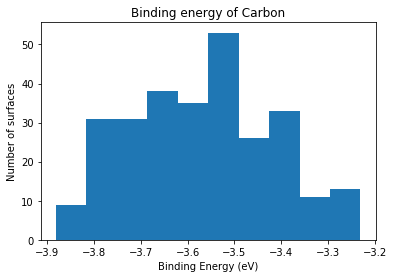

In [12]:
#Combining all the data together

%matplotlib inline
import matplotlib.pyplot as plt
mono_BE = np.asarray(ea_list)
bimetal_BE = np.asarray(ea_list2)
#print(mono_BE.shape)
#print(bimetal_BE.shape)

x = np.concatenate((feature_matrix,feature_matrix2))
print(x.shape)
y = np.concatenate((mono_BE,bimetal_BE))

#Visualize the binding energy range of our dataset

plt.hist(y)
plt.title('Binding energy of Carbon')
plt.xlabel('Binding Energy (eV)')
plt.ylabel('Number of surfaces')

#comments: the range seems small, probably due to EMT not being a good calculator + sample size
print('Mean:',np.mean(y)) #mean binding energy
print('Std dev:',np.std(y)) #standard deviation
print('Range:',np.ptp(y)) #range

## Methods Cont'd
### 2. Building the Model(s)

    Now that we have the data organized into numpy arrays, we can now begin building models and evaluating their performances. As a starting point, we begin testing a simple linear regression model to test how well the feature vector data fits an equation to effectively predict the binding energy of a surface. Once that part if evaluated, we will attempt to improve the initial  performance by adjusting the feature size and by testing more complex models.

## Results and Discussion

### I. Linear Regression Model
     
    The linear regression model gave a high regression score of 0.929, but when looking at the error graph, we can see that there is a relatively large difference between the predicted and true binding energy with a max difference of about 0.15 eV. Given the small range of binding energies in this dataset (0.65 eV), I would consider this error to be relatively large. In order to improve the results, we will attempt to reduce the dimensionality of the data components.
    

Regression score: 0.929


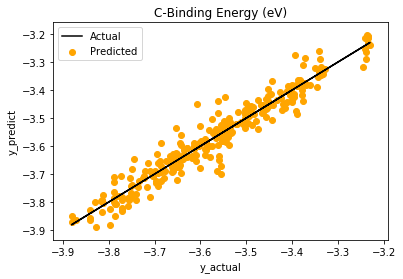

In [13]:
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

reg = LinearRegression().fit(x,y)
print('Regression score:',np.round(reg.score(x,y),3))

y_pred = reg.predict(x)
plt.plot(y,y,c='black')

plt.scatter(y,y_pred,c='orange')
plt.title('C-Binding Energy (eV)')
plt.ylabel('y_predict')
plt.xlabel('y_actual')
plt.legend(['Actual','Predicted'])


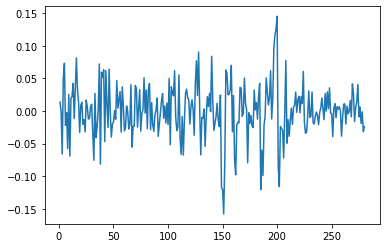

In [14]:
# Residual Error plot to easily visualize the errors of each data point
n = np.linspace(1,280,280)
plt.plot(n,y-y_pred)


###  II. PCA
   Given the large amount of features that we have, we want to determine which features are most important in determining the property. In order to do this, we will use data preprocessing in order to better fit our model. Initially, we are uncertain which features are necessary to keep, so one way of determining this is through trial and error. Through reducing the feature dimensions, our model's performance had significant improvement, with a regression score of 0.989 with a max error of around 0.06 eV. However, as seen from the below figures, removing too many features will cause the performance to drop drastically. Lowering the number of features from 324 to 5 caused the regression score to drop to 0.243, with a max error of around 0.4 eV. 

Regression score: 0.989


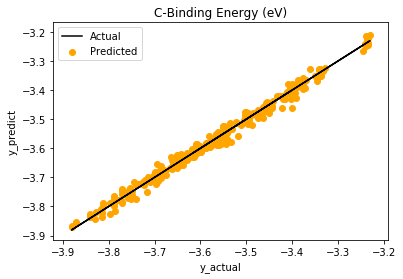

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
pca.fit(x)
#print(pca.explained_variance_ratio_)
x_red = pca.transform(x)

reg = LinearRegression().fit(x_red,y)
print('Regression score:',np.round(reg.score(x_red,y),3))
y_pred = reg.predict(x_red)

plt.plot(y,y,c='black')
plt.scatter(y,y_pred,c='orange')
plt.title('C-Binding Energy (eV)')
plt.ylabel('y_predict')
plt.xlabel('y_actual')
plt.legend(['Actual','Predicted'])

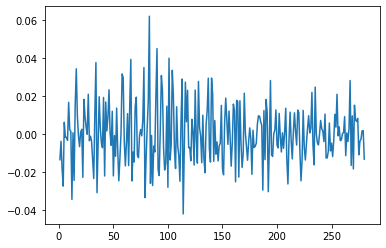

In [16]:
# Residual Error plot to easily visualize the errors of each data point
n = np.linspace(1,280,280)
plt.plot(n,y-y_pred)


Regression score: 0.243


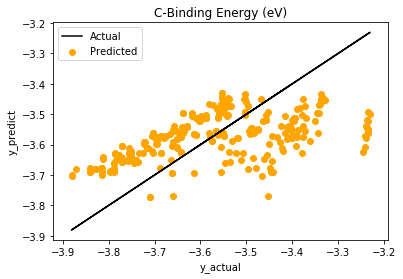

In [17]:
# Removing too many features 
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(x)
x_red = pca.transform(x)
#print(pca.explained_variance_ratio_)
reg = LinearRegression().fit(x_red,y)
print('Regression score:',np.round(reg.score(x_red,y),3))
y_pred = reg.predict(x_red)

plt.plot(y,y,c='black')
plt.scatter(y,y_pred,c='orange')
plt.title('C-Binding Energy (eV)')
plt.ylabel('y_predict')
plt.xlabel('y_actual')
plt.legend(['Actual','Predicted'])

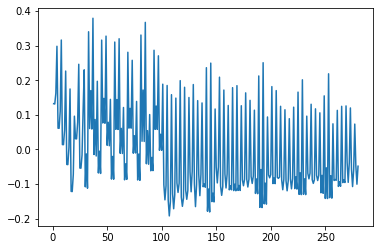

In [18]:
# Residual Error plot to easily visualize the errors of each data point
n = np.linspace(1,280,280)
plt.plot(n,y-y_pred)


###  III. Multi Layer Perceptron

    The Multi Layer Perceptron (MLP) is much more complex than a simple linear regression model, so it requires more parameters to be specified to be fit to the data. Additionally, MLPs are a nonlinear model so they are more flexible in terms of function. From the testing of the neural network with the same data, we obtained a higher model score of 0.984 as well as lower maximum error of 0.08 eV. When applying the same feature dimension reduction technique to the MLP as we did with the previous linear regression model, there was only a small increase in score to 0.989 and a small decrease in absolute error (max error: 0.076 eV).

In [19]:
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

# First we want to split our data into a test/training set

(x_train,x_test, y_train,y_test) = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(224, 324)
(56, 324)
(224,)
(56,)


Training Mean Squared Error: 0.00032 eV
Training Mean Absolute Error: 0.01257 eV
Testing Mean Squared Error: 0.00128 eV
Testing Mean Absolute Error: 0.02808 eV
Model score: 0.987
Max Error: 0.079


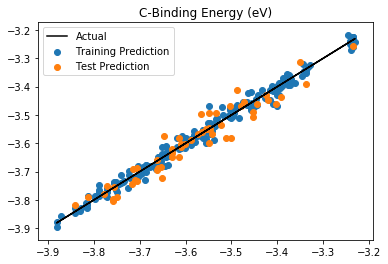

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#creating a MLP model
model = MLPRegressor(hidden_layer_sizes=(324,162,80),activation='tanh',solver='lbfgs',max_iter=5000)
model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

training_rms = mean_squared_error(y_train,y_pred_train)
print('Training Mean Squared Error:',np.round(training_rms,5), 'eV')

training_mae = mean_absolute_error(y_train,y_pred_train)
print('Training Mean Absolute Error:',np.round(training_mae,5), 'eV')

testing_rms = mean_squared_error(y_test,y_pred_test)
print('Testing Mean Squared Error:',np.round(testing_rms,5), 'eV')

testing_mae = mean_absolute_error(y_test,y_pred_test)
print('Testing Mean Absolute Error:',np.round(testing_mae,5), 'eV')

print('Model score:',np.round(model.score(x_train,y_train),3))

print('Max Error:',np.round(np.max(np.absolute(y_train-y_pred_train)),3))

# plot prediction vs observed
plt.plot(y,y,color='black')
plt.title('C-Binding Energy (eV)')
plt.scatter(y_train,y_pred_train)
plt.scatter(y_test,y_pred_test)
plt.legend(['Actual','Training Prediction','Test Prediction'])

(224, 150)
(56, 150)
(224,)
(56,)
Training Mean Squared Error: 0.00027 eV
Training Mean Absolute Error: 0.0111 eV
Testing Mean Squared Error: 0.00145 eV
Testing Mean Absolute Error: 0.02783 eV
Model score: 0.989
Max Error: 0.08


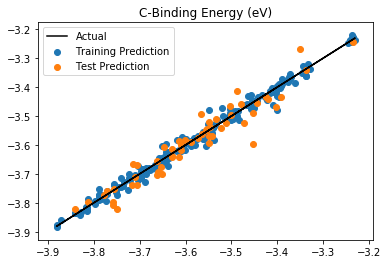

In [21]:
#Repeat of above process with implementation of feature reduction

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
pca = PCA(n_components=150)
pca.fit(x)
#print(pca.explained_variance_ratio_)
x_red = pca.transform(x)

from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

# First we want to split our data into a test/training set

(x_train,x_test, y_train,y_test) = train_test_split(x_red,y,test_size=0.2,shuffle=True,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


model = MLPRegressor(hidden_layer_sizes=(150,75,40),activation='tanh',solver='lbfgs',max_iter=5000)
model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

training_rms = mean_squared_error(y_train,y_pred_train)
print('Training Mean Squared Error:',np.round(training_rms,5), 'eV')

training_mae = mean_absolute_error(y_train,y_pred_train)
print('Training Mean Absolute Error:',np.round(training_mae,5), 'eV')

testing_rms = mean_squared_error(y_test,y_pred_test)
print('Testing Mean Squared Error:',np.round(testing_rms,5), 'eV')

testing_mae = mean_absolute_error(y_test,y_pred_test)
print('Testing Mean Absolute Error:',np.round(testing_mae,5), 'eV')

print('Model score:',np.round(model.score(x_train,y_train),3))

print('Max Error:',np.round(np.max(np.absolute(y_train-y_pred_train)),3))

plt.plot(y,y,color='black')
plt.title('C-Binding Energy (eV)')
plt.scatter(y_train,y_pred_train)
plt.scatter(y_test,y_pred_test)
plt.legend(['Actual','Training Prediction','Test Prediction'])

## Conclusion

    For this specific dataset, the method which transformed the data of the structures into a feature vector that described each structure seemed to lead to effective predictions with the models used in this project. Additionally, importance in model choice was shown as the MLP provided significantly better results than the simple linear regression model likely due to the fact that it is better suited for nonlinear regression. Another important takeaway was the effects of the number of features used, as it appeared that eliminating some of the features led to a better fit of the model. Additionally, reduction of the features for the MLP only caused a small increase in accuracy, but it did seem to run significantly faster. Due to the data range being small, it is difficult to determine how truly accurate the models would work with a larger data set with a more realistic variance. 

## References:

(1) Larsen, A. H.; Mortensen, J. J.; Blomqvist, J.; Castelli, I. E.; Christensen, R.; Du\lak, M.; 
Friis, J.; Groves, M. N.; Hammer, B.; Hargus, C.; Hermes, E. D.; Jennings, P. C.; Jensen, P. B.; 
Kermode, J.; Kitchin, J. R.; Kolsbjerg, E. L.; Kubal, J.; Kaasbjerg, K.; Lysgaard, S.; Maronsson, J. B.; 
Maxson, T.; Olsen, T.; Pastewka, L.; Peterson, A.; Rostgaard, C.; Schiøtz, J.; Schütt, O.; Strange, M.; 
Thygesen, K. S.; Vegge, T.; Vilhelmsen, L.; Walter, M.; Zeng, Z.; Jacobsen, K. W. 
The Atomic Simulation Environment—a Python Library for Working with Atoms. 
J. Phys.: Condens. Matter 2017, 29 (27), 273002. https://doi.org/10.1088/1361-648X/aa680e.

(2) Lauri Himanen, Marc O.J. Jäger, Eiaki V. Morooka, Filippo Federici Canova, Yashasvi S. Ranawat, David Z. Gao, Patrick Rinke, Adam S. Foster,
DScribe: Library of descriptors for machine learning in materials science,
Computer Physics Communications,
Volume 247,
2020,
106949,
ISSN 0010-4655,
https://doi.org/10.1016/j.cpc.2019.106949.

